In [1]:
import sys
import pandas as pd
import networkx as nx
import igraph as ig
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def get_size(obj):
    """Recursively finds the size of objects including contents."""
    seen_ids = set()
    size = 0
    objects = [obj]
    while objects:
        obj = objects.pop()
        if id(obj) in seen_ids:
            continue
        seen_ids.add(id(obj))
        size += sys.getsizeof(obj)
        objects.extend(getattr(obj, '__dict__', {}).values())
        if isinstance(obj, dict):
            objects.extend(obj.items())
        elif isinstance(obj, (list, tuple, set, frozenset)):
            objects.extend(obj)
    return size

In [3]:
def get_igraph_size(graph):
    total_size = sys.getsizeof(graph)

    # Add the size of the vertices
    for vertex in graph.vs:
        total_size += sys.getsizeof(vertex)
        total_size += sys.getsizeof(vertex.attributes())

    # Add the size of the edges
    for edge in graph.es:
        total_size += sys.getsizeof(edge)
        total_size += sys.getsizeof(edge.attributes())

    return total_size

In [4]:
dgraphfin_np_file = np.load("../data/dgraph_dataset/dgraphfin.npz")

In [5]:
dgraphfin_np_file.files

['x',
 'y',
 'edge_index',
 'edge_type',
 'edge_timestamp',
 'train_mask',
 'valid_mask',
 'test_mask']

## Static graph analysis

In [6]:
G_igraph = ig.Graph(edges=dgraphfin_np_file['edge_index'],directed=True)

In [7]:
print(f"Graph size in memory:{get_igraph_size(G_igraph)}")
print(G_igraph.summary())

Graph size in memory:832161344
IGRAPH D--- 3700550 4300999 -- 


## Degree Distribution

Number of Isolated nodes:0


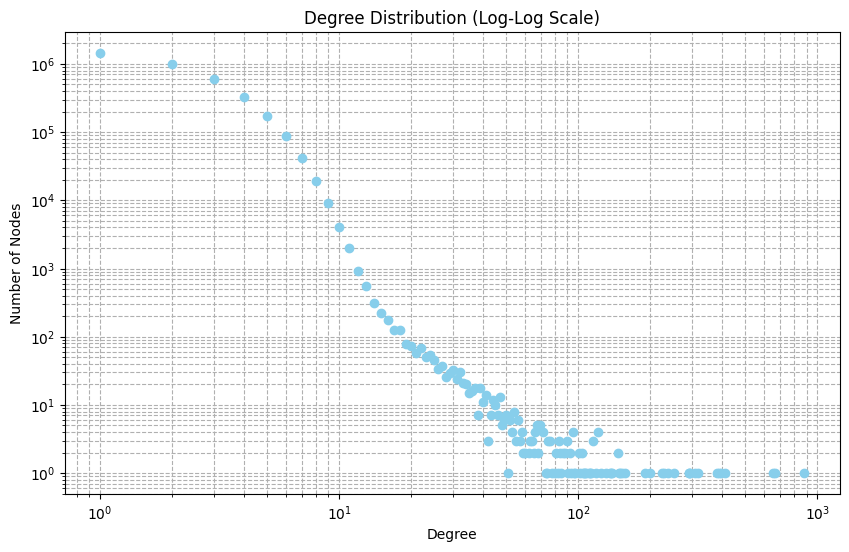

In [8]:
degrees = G_igraph.degree()
degree_counts = [degrees.count(i) for i in range(max(degrees) + 1)]
print(f"Number of Isolated nodes:{degree_counts[0]}")
nonzero_degrees = [(i, count) for i, count in enumerate(degree_counts) if count > 0]
x, y = zip(*nonzero_degrees)
plt.figure(figsize=(10, 6))
plt.loglog(x, y, marker='o', linestyle='None', color='skyblue')
plt.title("Degree Distribution (Log-Log Scale)")
plt.xlabel("Degree")
plt.ylabel("Number of Nodes")
plt.grid(True, which="both", ls="--")
plt.show()

## Features stats

In [9]:
node_features = dgraphfin_np_file['x']
mean = np.mean(node_features, axis=0)
median = np.median(node_features,axis=0)
std_dev = np.std(node_features,axis=0)
min_vals = np.min(node_features,axis=0)
max_vals = np.max(node_features,axis=0)
print("Feature Summary Statistics:")
for i in range(node_features.shape[1]):
    print(f"Feature {i}:")
    print(f"  Mean: {mean[i]:.2f}")
    print(f"  Median: {median[i]:.2f}")
    print(f"  Std Dev: {std_dev[i]:.2f}")
    print(f"  Min: {min_vals[i]:.2f}")
    print(f"  Max: {max_vals[i]:.2f}")
    print()

Feature Summary Statistics:
Feature 0:
  Mean: 0.51
  Median: 1.00
  Std Dev: 0.74
  Min: -1.00
  Max: 1.00

Feature 1:
  Mean: 3.08
  Median: 3.00
  Std Dev: 2.63
  Min: -1.00
  Max: 8.00

Feature 2:
  Mean: -0.09
  Median: -1.00
  Std Dev: 1.43
  Min: -1.00
  Max: 153.51

Feature 3:
  Mean: -0.16
  Median: -1.00
  Std Dev: 1.31
  Min: -1.00
  Max: 153.38

Feature 4:
  Mean: -0.15
  Median: -1.00
  Std Dev: 0.92
  Min: -1.00
  Max: 1.00

Feature 5:
  Mean: -0.20
  Median: -1.00
  Std Dev: 1.33
  Min: -1.00
  Max: 456.30

Feature 6:
  Mean: 0.09
  Median: -1.00
  Std Dev: 1.91
  Min: -1.00
  Max: 68.65

Feature 7:
  Mean: -0.51
  Median: -1.00
  Std Dev: 0.62
  Min: -1.00
  Max: 12.68

Feature 8:
  Mean: 0.07
  Median: -1.00
  Std Dev: 1.87
  Min: -1.00
  Max: 68.03

Feature 9:
  Mean: -0.11
  Median: -1.00
  Std Dev: 0.97
  Min: -1.00
  Max: 1.00

Feature 10:
  Mean: 0.74
  Median: 0.00
  Std Dev: 2.45
  Min: 0.00
  Max: 1313.00

Feature 11:
  Mean: -0.51
  Median: -1.00
  Std Dev: 0.

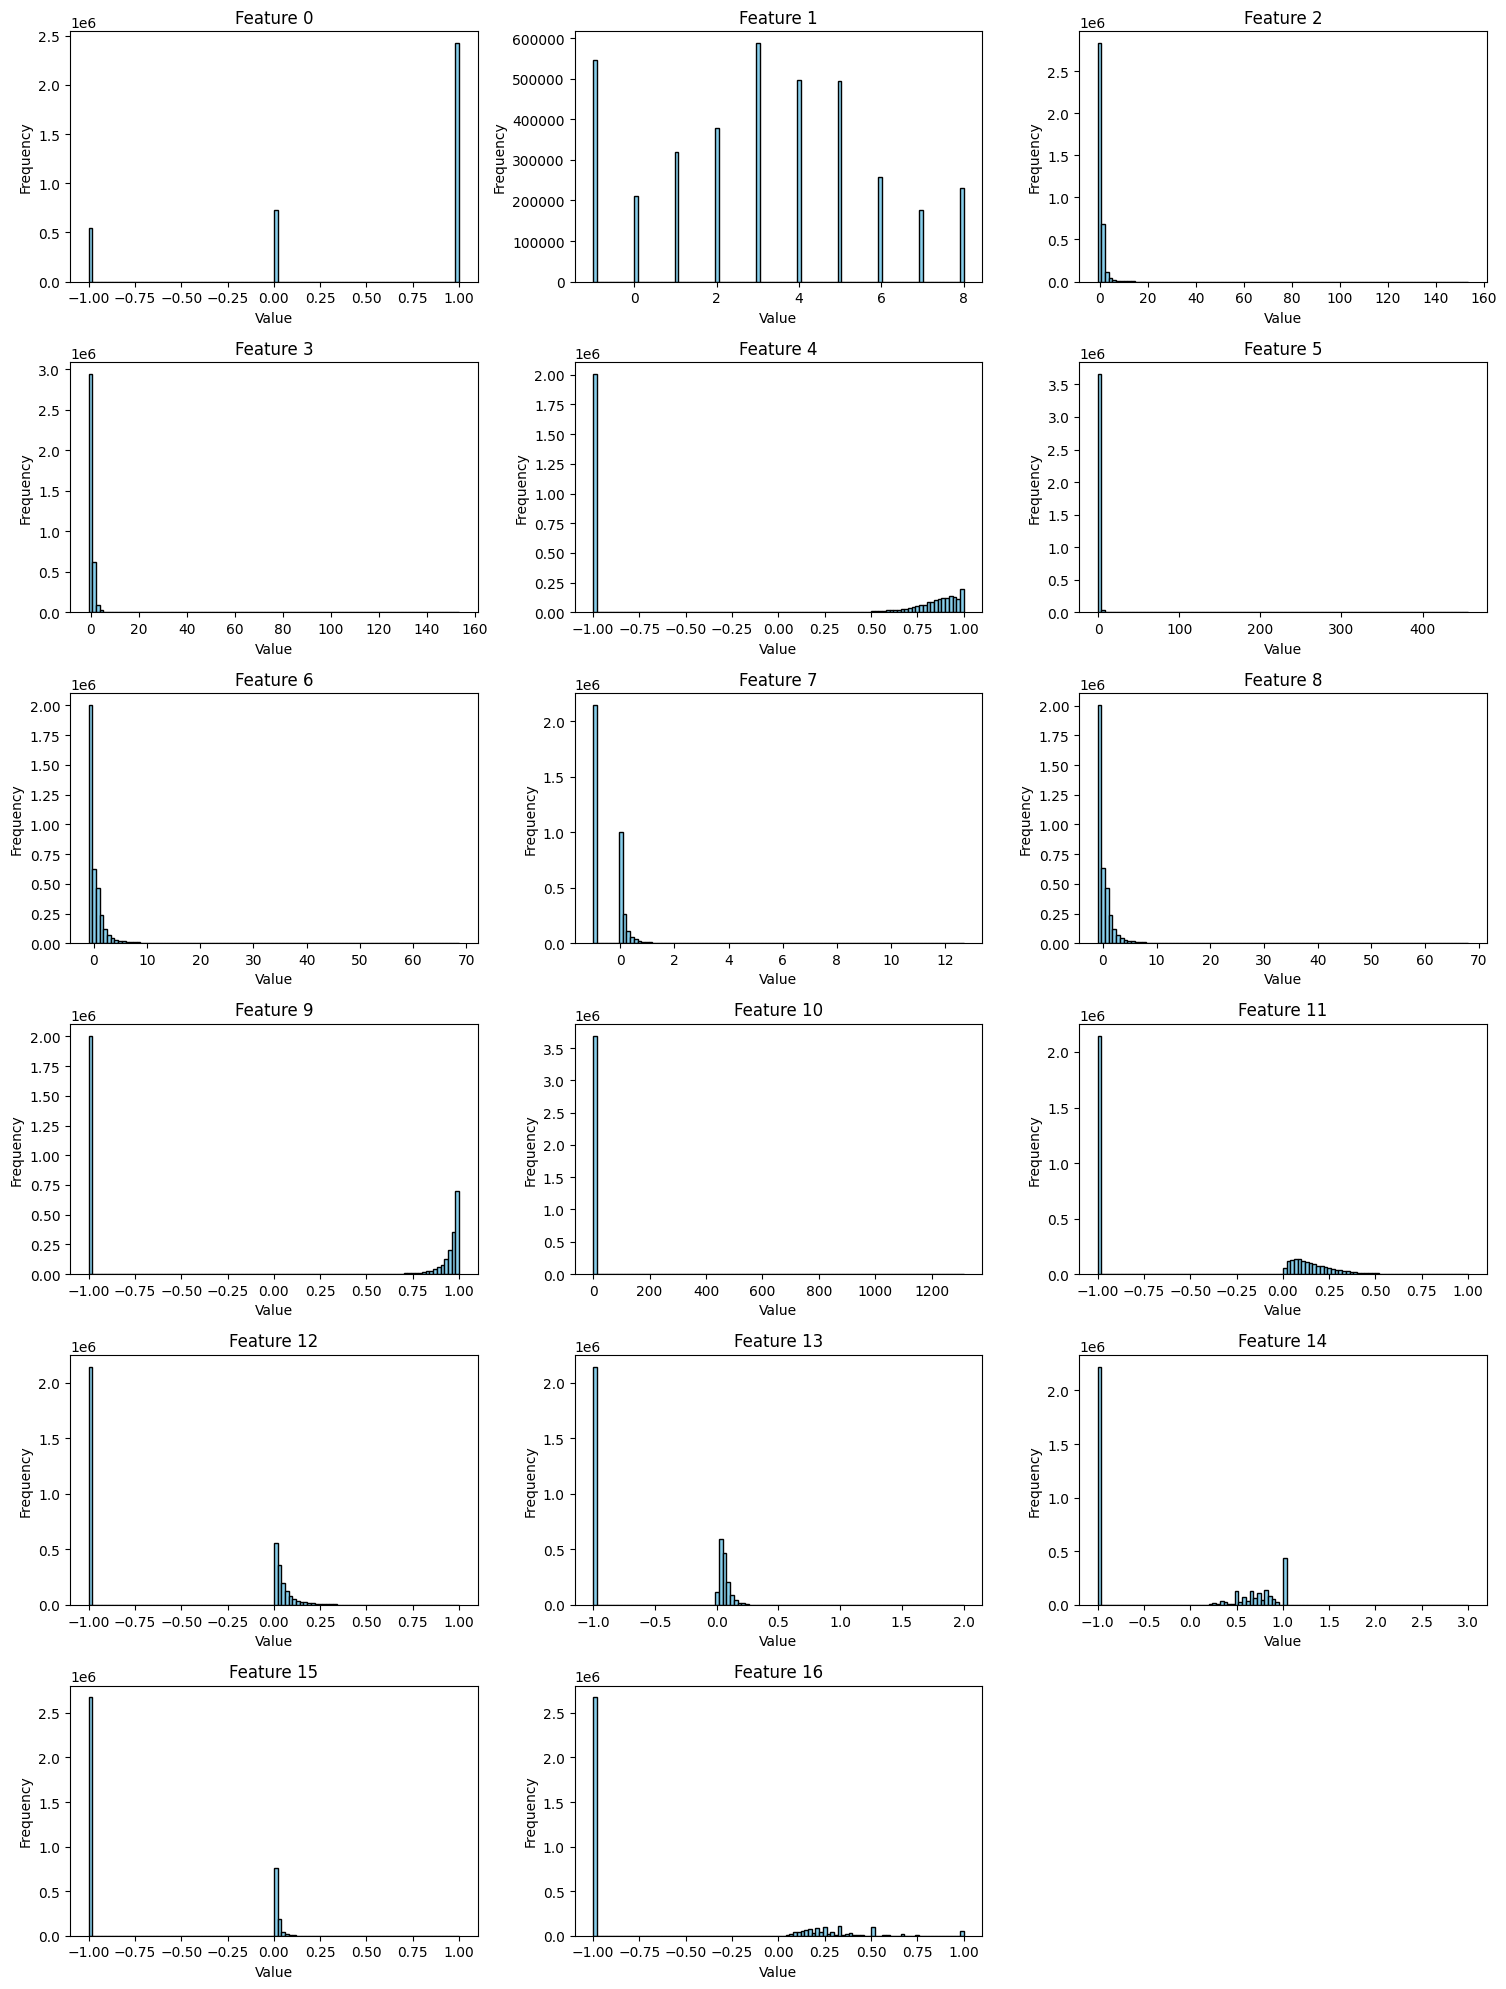

In [10]:
fig, axes = plt.subplots(6, 3, figsize=(15, 20))
axes = axes.flatten()  # Flatten the 2D array of axes to make indexing easier

# Plot histograms for each feature
for i in range(17):
    axes[i].hist(node_features[:, i], bins=100, color='skyblue', edgecolor='black')
    axes[i].set_title(f'Feature {i}')
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')

# Remove unused subplots
for j in range(17, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## Label stats

3700550


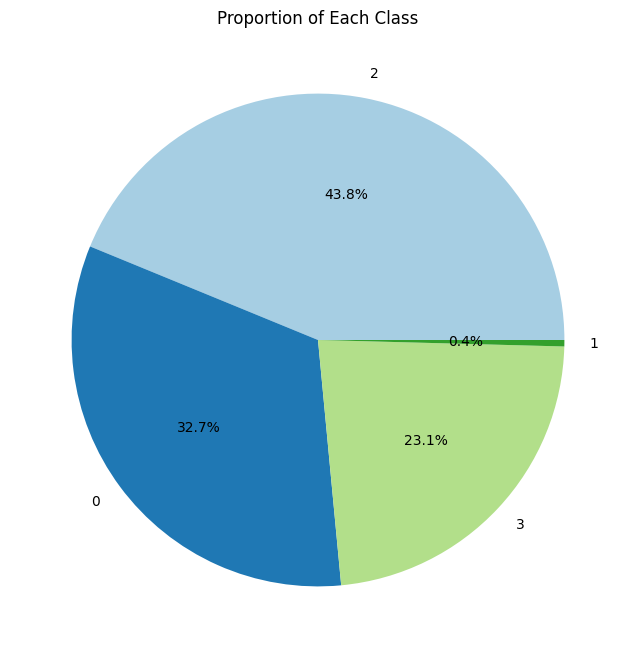

In [11]:
labels = dgraphfin_np_file['y']
print(len(labels))
labels_df = pd.DataFrame(labels,columns=["labels"])
class_counts = labels_df['labels'].value_counts()
plt.figure(figsize=(8, 8))
class_counts.plot(kind='pie', autopct='%1.1f%%', colors=plt.cm.Paired(range(len(class_counts))))
plt.title('Proportion of Each Class')
plt.ylabel('')  # Hide the y-label
plt.show()

## Dynamic Analysis

In [19]:
edge_time_stamp = dgraphfin_np_file['edge_timestamp']
edge_time_stamp = edge_time_stamp[:,np.newaxis]
edge_type = dgraphfin_np_file['edge_type']
edge_type = edge_type[:,np.newaxis]
edge_index = dgraphfin_np_file['edge_index']
print(len(edge_index))
print(len(edge_time_stamp))
print(len(edge_type))
edge_list = np.concatenate((edge_index,edge_type,edge_time_stamp),axis=1)
edge_list_df = pd.DataFrame(edge_list,columns=["src","dest","weight","timestamp"])
edge_list_df['year'] = edge_list_df['timestamp']//365
edge_list_df['month'] = (edge_list_df['timestamp']-1)//30
edge_list_df['week'] = (edge_list_df['timestamp']-1)//7
edge_list_df

4300999
4300999
4300999


,src,dest,weight,timestamp,year,month,week
0,476699,2915516,10,254,0,8,36
1,347800,1271242,10,266,0,8,37
2,154317,2104635,10,240,0,7,34
3,497847,3281634,10,474,1,15,67
4,1541244,372144,10,7,0,0,0
...,...,...,...,...,...,...,...
4300994,3577329,1857679,8,745,2,24,106
4300995,356284,1173002,4,483,1,16,68
4300996,1894383,1147595,6,378,1,12,53
4300997,1895741,1314434,3,594,1,19,84


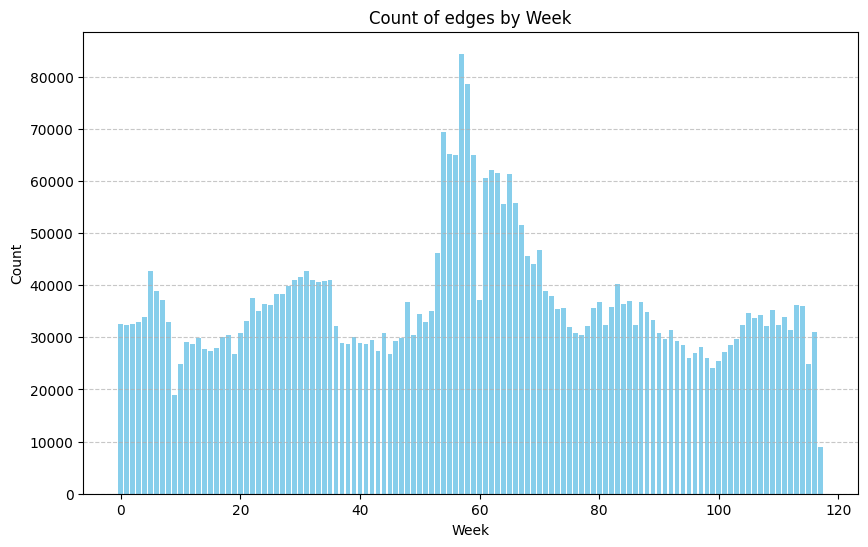

In [20]:
weekly_counts = edge_list_df.groupby('week').size()

weekly_counts_df = weekly_counts.reset_index(name='count')

plt.figure(figsize=(10, 6))
plt.bar(weekly_counts_df['week'], weekly_counts_df['count'], color='skyblue')
plt.xlabel('Week')
plt.ylabel('Count')
plt.title('Count of edges by Week')
# plt.xticks(weekly_counts_df['week'])  # Ensure all x-ticks are shown
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [21]:
weekly_counts

week
0      32454
1      32397
2      32568
3      32966
4      33804
       ...  
113    36249
114    36033
115    24814
116    30934
117     9016
Length: 118, dtype: int64

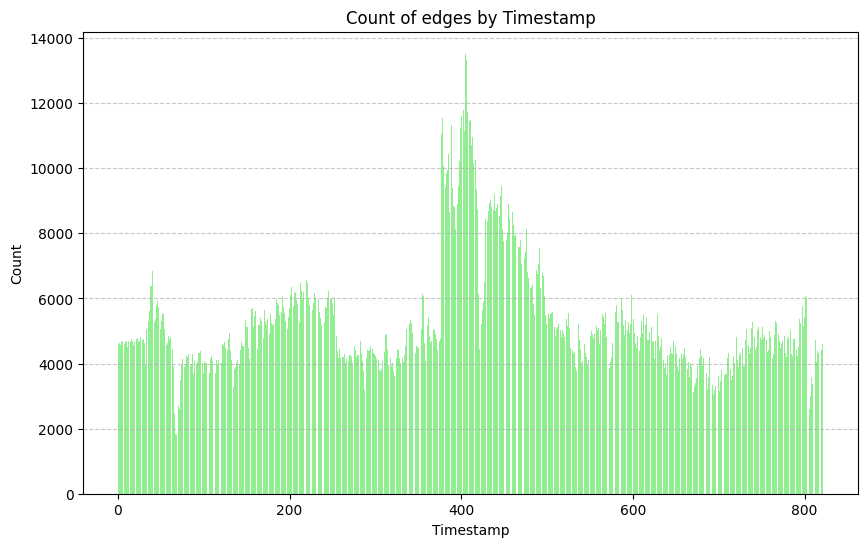

In [14]:
timestamp_counts = edge_list_df.groupby('timestamp').size()

timestamp_counts_df = timestamp_counts.reset_index(name='count')

plt.figure(figsize=(10, 6))
plt.bar(timestamp_counts_df['timestamp'], timestamp_counts_df['count'], color='lightgreen')
plt.xlabel('Timestamp')
plt.ylabel('Count')
plt.title('Count of edges by Timestamp')
# plt.xticks(timestamp_counts_df['timestamp'])  # Ensure all x-ticks are shown
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

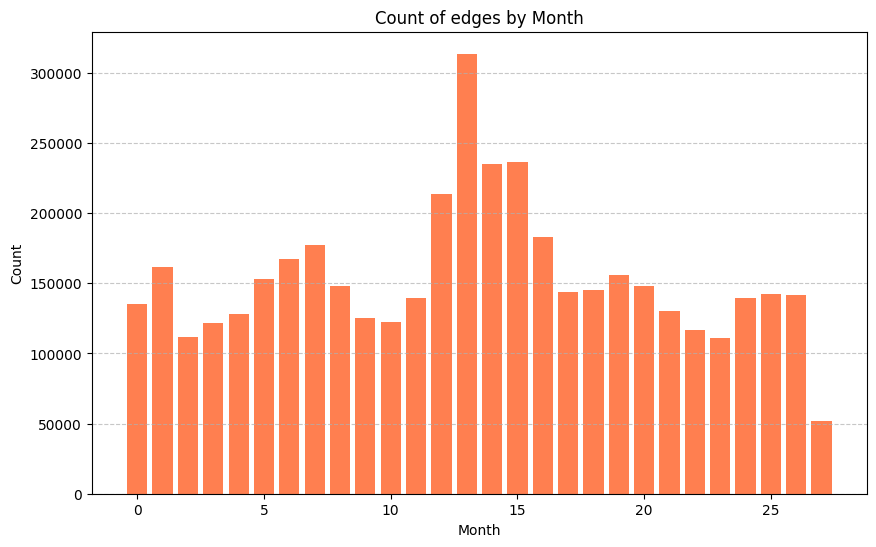

In [77]:
monthly_counts = edge_list_df.groupby('month').size()

monthly_counts_df = monthly_counts.reset_index(name='count')

plt.figure(figsize=(10, 6))
plt.bar(monthly_counts_df['month'], monthly_counts_df['count'], color='coral')
plt.xlabel('Month')
plt.ylabel('Count')
plt.title('Count of edges by Month')
# plt.xticks(monthly_counts_df['month'])  # Ensure all x-ticks are shown
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [51]:
np.max(edge_index,axis=0)

array([3699087, 3700549])

In [14]:
nodes_array = dgraphfin_np_file['x']
nodes_array

array([[ 0.,  5., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [ 0.,  5., -1., ..., -1., -1., -1.],
       ...,
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.]])

In [8]:
array_name = dgraphfin_np_file['edge_timestamp']

In [12]:
print(array_name.min())
print(array_name.max())

1
821


In [13]:
edge_type_array = dgraphfin_np_file['edge_type']
edge_type_array

array([10, 10, 10, ...,  6,  3,  1])